# Python: Difference-in-Differences

**Remark:**
*This notebook is based on the deprecated version of the DiD implementation of DoubleML. Please check out the [DiD Section](https://docs.doubleml.org/dev/guide/models.html#difference-in-differences-models-did) to find out about the current implementation.*

In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the average treatment effect on the treated (ATT) under the conditional parallel trend assumption. The estimation is based on [Chang (2020)](https://doi.org/10.1093/ectj/utaa001), [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003) and [Zimmert et al. (2018)](https://arxiv.org/abs/1809.01643).

In this example, we will adopt the notation of [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003).

In the whole example our treatment and time variable $t\in\{0,1\}$ will be binary. 
Let $D_i\in\{0,1\}$ denote the treatment status of unit $i$ at time $t=1$ (at time $t=0$ all units are not treated) and let $Y_{it}$ be the outcome of interest of unit $i$ at time $t$.
Using the potential outcome notation, we can write $Y_{it}(d)$ for the potential outcome of unit $i$ at time $t$ and treatment status $d$. Further, let $X_i$ denote a vector of pre-treatment covariates.
In these difference-in-differences settings [Abadie (2005)](https://doi.org/10.1111/0034-6527.00321) showed that the ATTE

$$\theta = \mathbb{E}[Y_{i1}(1)- Y_{i1}(0)|D_i=1]$$

is identified when panel data are available or under stationarity assumptions for repeated cross-sections. Further, the basic assumptions are 

 - **Parallel Trends:** We have $\mathbb{E}[Y_{i1}(0) - Y_{i0}(0)|X_i, D_i=1] = \mathbb{E}[Y_{i1}(0) - Y_{i0}(0)|X_i, D_i=0]\quad a.s.$

- **Overlap:** For some $\epsilon > 0$, $P(D_i=1) > \epsilon$ and $P(D_i=1|X_i) \le 1-\epsilon$ a.s.

For a detailed explanation of the assumptions see e.g. [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003) or [Zimmert et al. (2018)](https://arxiv.org/abs/1809.01643).

## Panel Data (Repeated Outcomes)

At first, we will consider two-period panel data, where we observe i.i.d. data $W_i = (Y_{i0}, Y_{i1}, D_i, X_i)$.

### Data

We will use the implemented data generating process `make_did_SZ2020` to generate data according to the simulation in [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003) (Section 4.1). 

In this example, we will use `dgp_tpye=4`, which corresponds to the misspecified settings in [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003) (other data generating processes are also available via the `dgp_type` parameter). In all settings the true ATTE is zero.

To specify a corresponding `DoubleMLData` object, we have to specify a single outcome `y`. For panel data, the outcome consists of the difference of 

$$\Delta Y_i = Y_{i1}- Y_{i0}.$$

This difference will then be defined as outcome in our `DoubleMLData` object. The data generating process `make_did_SZ2020` already specifies the outcome `y` accordingly.

In [9]:
import numpy as np
from doubleml.did.datasets import make_did_SZ2020
from doubleml import DoubleMLDIDData

np.random.seed(42)
n_obs = 1000
x, y, d, _ = make_did_SZ2020(n_obs=n_obs, dgp_type=4, cross_sectional_data=False, return_type='array')
dml_data = DoubleMLDIDData.from_arrays(x=x, y=y, d=d)
print(dml_data)

================== DoubleMLDIDData Object ==================
Time variable: None
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4']
Instrument variable(s): None
No. Observations: 1000




### ATTE Estimation

To estimate the ATTE with panel data, we will use the `DoubleMLDID` class. 

As for all `DoubleML` classes, we have to specify learners, which have to be initialized first.
Here, we will just rely on a tree based method. 

The learner `ml_g` is used to fit conditional expectations of the outcome $\mathbb{E}[\Delta Y_i|D_i=0, X_i]$, whereas the learner `ml_m` will be used to estimate the propensity score $P(D_i=1|X_i)$.

In [10]:
from lightgbm import LGBMClassifier, LGBMRegressor

n_estimators = 30
ml_g = LGBMRegressor(n_estimators=n_estimators, verbose=-1)
ml_m = LGBMClassifier(n_estimators=n_estimators, verbose=-1)

The `DoubleMLDID` class can be used as any other `DoubleML` class. 

The score is set to `score='observational'`, since the we generated data where the treatment probability depends on the pretreatment covariates. Further, we will use `in_sample_normalization=True`, since normalization generally improved the results in our simulations (both `score='observational'` and `in_sample_normalization=True` are default values).

After initialization, we have to call the `fit()` method to estimate the nuisance elements.

In [11]:
from doubleml import DoubleMLDID
dml_did = DoubleMLDID(dml_data, 
                      ml_g=ml_g, 
                      ml_m=ml_m,
                      score='observational',
                      in_sample_normalization=True,
                      n_folds=5)

dml_did.fit()
print(dml_did)

================== DoubleMLDID Object ==================

------------------ Data Summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4']
Instrument variable(s): None
No. Observations: 1000


------------------ Score & Algorithm ------------------
Score function: observational

------------------ Machine Learner   ------------------
Learner ml_g: LGBMRegressor(n_estimators=30, verbose=-1)
Learner ml_m: LGBMClassifier(n_estimators=30, verbose=-1)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[11.55855122]]
Learner ml_g1 RMSE: [[11.38983785]]
Classification:
Learner ml_m Log Loss: [[0.67674909]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit Summary       ------------------
       coef  std err         t     P>|t|     2.5 %    97.5 %
d  0.305272  1.25855  0.242559  0.808347 -2.161441  2.771986


As usual, confidence intervals at different levels can be obtained via

In [12]:
print(dml_did.confint(level=0.90))

      5.0 %    95.0 %
d -1.764859  2.375403


### Coverage Simulation

Here, we add a small coverage simulation to highlight the difference to the linear implementation of [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003). We generate multiple datasets, estimate the ATTE and collect the results (this may take some time). 

In [13]:
n_rep = 200
ATTE = 0.0

ATTE_estimates = np.full((n_rep), np.nan)
coverage = np.full((n_rep), np.nan)
ci_length = np.full((n_rep), np.nan)

np.random.seed(42)
for i_rep in range(n_rep):
    if (i_rep % int(n_rep/10)) == 0:
        print(f'Iteration: {i_rep}/{n_rep}')
    dml_data = make_did_SZ2020(n_obs=n_obs, dgp_type=4, cross_sectional_data=False)

    dml_did = DoubleMLDID(dml_data, ml_g=ml_g, ml_m=ml_m, n_folds=5)
    dml_did.fit()

    ATTE_estimates[i_rep] = dml_did.coef.squeeze()
    confint = dml_did.confint(level=0.95)
    coverage [i_rep] = (confint['2.5 %'].iloc[0] <= ATTE) & (ATTE <= confint['97.5 %'].iloc[0])
    ci_length[i_rep] = confint['97.5 %'].iloc[0] - confint['2.5 %'].iloc[0]

Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200


Let us take a look at the corresponding coverage and the length of the confidence intervals.

In [14]:
print(f'Coverage: {coverage.mean()}')
print(f'Average CI length: {ci_length.mean()}')

Coverage: 0.965
Average CI length: 5.517510812139451


Here, we can observe that the coverage is still valid, since we did not rely on linear learners, so the setting is not misspecified in this example. 

If we know the conditional expectation is correctly specified (linear form), we can use this to obtain smaller confidence intervals but in many applications, we may want to safeguard against misspecification and use flexible models such as random forest or boosting.

The distribution of the estimates takes the following form

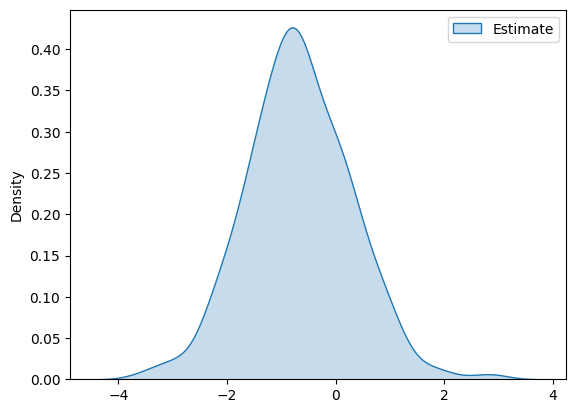

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_pa = pd.DataFrame(ATTE_estimates, columns=['Estimate'])
g = sns.kdeplot(df_pa, fill=True)
plt.show()

## Repeated Cross-Sectional Data

For repeated cross-sectional data, we assume that we observe i.i.d. data $W_i = (Y_{i}, D_i, X_i, T_i)$. 

Here $Y_i = T_i Y_{i1} + (1-T_i)Y_{i0}$ corresponds to the outcome of unit $i$ which is observed at time $T_i$.

### Data

As for panel data, we will use the implemented data generating process `make_did_SZ2020` to generate data according to the simulation in [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003) (Section 4.2). 

In this example, we will use `dgp_tpye=4`, which corresponds to the misspecified settings in [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003) (other data generating processes are also available via the `dgp_type` parameter). In all settings the true ATTE is zero.

In contrast to other `DoubleMLData` objects, we have to specify which column corresponds to our time variable $T$.

The time variable can be simply set via the argument `t`.

In [16]:
import numpy as np
from doubleml.did.datasets import make_did_SZ2020
from doubleml import DoubleMLData

np.random.seed(42)
n_obs = 1000
x, y, d, t = make_did_SZ2020(n_obs=n_obs, dgp_type=4, cross_sectional_data=True, return_type='array')
dml_data = DoubleMLDIDData.from_arrays(x=x, y=y, d=d, t=t)
print(dml_data)

================== DoubleMLDIDData Object ==================
Time variable: t
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4']
Instrument variable(s): None
No. Observations: 1000




### ATTE Estimation

To estimate the ATTE with panel data, we will use the `DoubleMLDIDCS` class. 

As for all `DoubleML` classes, we have to specify learners, which have to be initialized first.
Here, we will just rely on a tree based method. 

The learner `ml_g` is used to fit conditional expectations of the outcome $\mathbb{E}[\Delta Y_i| D_i=d, T_i =t, X_i]$ for all combinations of $d,t\in\{0,1\}$, whereas the learner `ml_m` will be used to estimate the propensity score $P(D_i=1|X_i)$.

In [17]:
from lightgbm import LGBMClassifier, LGBMRegressor

n_estimators = 30
ml_g = LGBMRegressor(n_estimators=n_estimators)
ml_m = LGBMClassifier(n_estimators=n_estimators)

The `DoubleMLDIDCS` class can be used as any other `DoubleML` class. 

The score is set to `score='observational'`, since the we generated data where the treatment probability depends on the pretreatment covariates. Further, we will use `in_sample_normalization=True`, since normalization generally improved the results in our simulations (both `score='observational'` and `in_sample_normalization=True` are default values).

After initialization, we have to call the `fit()` method to estimate the nuisance elements.

In [18]:
from doubleml import DoubleMLDIDCS
dml_did = DoubleMLDIDCS(dml_data,
                        ml_g=ml_g,
                        ml_m=ml_m,
                        score='observational',
                        in_sample_normalization=True,
                        n_folds=5)

dml_did.fit()
print(dml_did)

================== DoubleMLDIDCS Object ==================

------------------ Data Summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4']
Instrument variable(s): None
No. Observations: 1000


------------------ Score & Algorithm ------------------
Score function: observational

------------------ Machine Learner   ------------------
Learner ml_g: LGBMRegressor(n_estimators=30)
Learner ml_m: LGBMClassifier(n_estimators=30)
Out-of-sample Performance:
Regression:
Learner ml_g_d0_t0 RMSE: [[14.54119805]]
Learner ml_g_d0_t1 RMSE: [[26.40359107]]
Learner ml_g_d1_t0 RMSE: [[27.98750578]]
Learner ml_g_d1_t1 RMSE: [[45.69520523]]
Classification:
Learner ml_m Log Loss: [[0.67618978]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit Summary       ------------------
       coef   std err         t     P>|t|     2.5 %     97.5 %
d  7.667682  5.809278  1.319903  

As usual, confidence intervals at different levels can be obtained via

In [19]:
print(dml_did.confint(level=0.90))

      5.0 %     95.0 %
d -1.887731  17.223095


### Coverage Simulation

Again, we add a small coverage simulation to highlight the difference to the linear implementation of [Sant'Anna and Zhao (2020)](https://doi.org/10.1016/j.jeconom.2020.06.003). We generate multiple datasets, estimate the ATTE and collect the results (this may take some time). 

In [20]:
n_rep = 200
ATTE = 0.0

ATTE_estimates = np.full((n_rep), np.nan)
coverage = np.full((n_rep), np.nan)
ci_length = np.full((n_rep), np.nan)

np.random.seed(42)
for i_rep in range(n_rep):
    if (i_rep % int(n_rep/10)) == 0:
        print(f'Iteration: {i_rep}/{n_rep}')
    dml_data = make_did_SZ2020(n_obs=n_obs, dgp_type=4, cross_sectional_data=True)

    dml_did = DoubleMLDIDCS(dml_data, ml_g=ml_g, ml_m=ml_m, n_folds=5)
    dml_did.fit()

    ATTE_estimates[i_rep] = dml_did.coef.squeeze()
    confint = dml_did.confint(level=0.95)
    coverage [i_rep] = (confint['2.5 %'].iloc[0] <= ATTE) & (ATTE <= confint['97.5 %'].iloc[0])
    ci_length[i_rep] = confint['97.5 %'].iloc[0] - confint['2.5 %'].iloc[0]

Iteration: 0/200
Iteration: 20/200
Iteration: 40/200
Iteration: 60/200
Iteration: 80/200
Iteration: 100/200
Iteration: 120/200
Iteration: 140/200
Iteration: 160/200
Iteration: 180/200


Let us take a look at the corresponding coverage and the length of the confidence intervals.

In [21]:
print(f'Coverage: {coverage.mean()}')
print(f'Average CI length: {ci_length.mean()}')

Coverage: 0.96
Average CI length: 23.357586986897548


As for panel data the coverage is still valid, since we did not rely on linear learners, so the setting is not misspecified in this example. 

If we know the conditional expectation is correctly specified (linear form), we can use this to obtain smaller confidence intervals but in many applications, we may want to safeguard against misspecification and use flexible models such as random forest or boosting.

The distribution of the estimates takes the following form

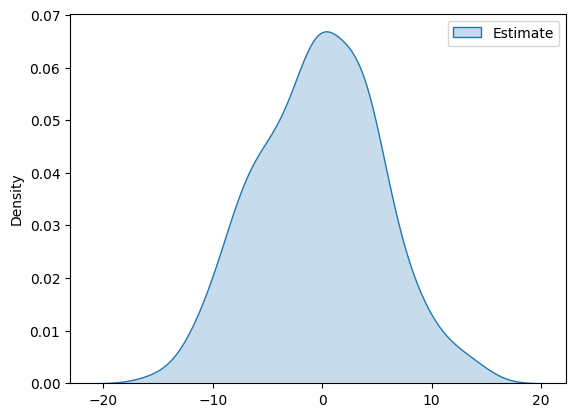

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_pa = pd.DataFrame(ATTE_estimates, columns=['Estimate'])
g = sns.kdeplot(df_pa, fill=True)
plt.show()